### Libs import

#### Primary libs

In [1]:
from tqdm.notebook import tqdm

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#### ML modules

Torch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import StepLR

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


Not Torch

In [4]:
import gc

from scipy.signal import correlate
from statsmodels.graphics.tsaplots import plot_acf
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Functions definings

### Dataloading

```python
PATH = 'data/binance/fut/hour'

close = dict()
open = dict()
high = dict()
low = dict()
qvolume = dict()
bvolume = dict()
ntrades = dict()
takerbuybvolume = dict()
takerbuyqvolume = dict()


for root, dirs, files in os.walk(PATH):
    for file in tqdm(files):
        data = pd.read_csv(f'{PATH}/{file}', index_col='openTime')
        data.drop(columns=['Unnamed: 0'], inplace=True)
        close[file[:-4]] = data['close']
        open[file[:-4]] = data['open']
        high[file[:-4]] = data['high']
        low[file[:-4]] = data['low']
        bvolume[file[:-4]] = data['baseVolume']
        qvolume[file[:-4]] = data['quoteVolume']
        ntrades[file[:-4]] = data['numTrades']
        takerbuybvolume[file[:-4]] = data['takerBuyBaseVolume']
        takerbuyqvolume[file[:-4]] = data['takerBuyQuoteVolume']

close = pd.DataFrame(close)
open = pd.DataFrame(open)
high = pd.DataFrame(high)
low = pd.DataFrame(low)
qvolume = pd.DataFrame(qvolume)
bvolume = pd.DataFrame(bvolume)
ntrades = pd.DataFrame(ntrades)
takerbuybvolume = pd.DataFrame(takerbuybvolume)
takerbuyqvolume = pd.DataFrame(takerbuyqvolume)
```

In [5]:
PATH = 'data/binance/fut/hour'

close = pd.read_csv(f'{PATH}/close.csv', index_col='openTime')
open = pd.read_csv(f'{PATH}/open.csv', index_col='openTime')
high = pd.read_csv(f'{PATH}/high.csv', index_col='openTime')
low = pd.read_csv(f'{PATH}/low.csv', index_col='openTime')
qvolume = pd.read_csv(f'{PATH}/qvolume.csv', index_col='openTime')
bvolume = pd.read_csv(f'{PATH}/bvolume.csv', index_col='openTime')
ntrades = pd.read_csv(f'{PATH}/ntrades.csv', index_col='openTime')
takerbuybvolume = pd.read_csv(f'{PATH}/takerbuybvolume.csv', index_col='openTime')
takerbuyqvolume = pd.read_csv(f'{PATH}/takerbuyqvolume.csv', index_col='openTime')

In [6]:
good_tickers = close.isna().sum()[close.isna().sum() < 10_000].index

close = close[good_tickers]
close.index = pd.to_datetime(close.index)
close = close.resample('4H').first()

open = open[good_tickers]
open.index = pd.to_datetime(open.index)
open = open.resample('4H').first()

high = high[good_tickers]
high.index = pd.to_datetime(high.index)
high = high.resample('4H').first()

low = low[good_tickers]
low.index = pd.to_datetime(low.index)
low = low.resample('4H').first()

bvolume = bvolume[good_tickers]
bvolume.index = pd.to_datetime(bvolume.index)
bvolume = bvolume.resample('4H').first()

qvolume = qvolume[good_tickers]
qvolume.index = pd.to_datetime(qvolume.index)
qvolume = qvolume.resample('4H').first()

ntrades = ntrades[good_tickers]
ntrades.index = pd.to_datetime(ntrades.index)
ntrades = ntrades.resample('4H').first()

takerbuybvolume = takerbuybvolume[good_tickers]
takerbuybvolume.index = pd.to_datetime(takerbuybvolume.index)
takerbuybvolume = takerbuybvolume.resample('4H').first()

takerbuyqvolume = takerbuyqvolume[good_tickers]
takerbuyqvolume.index = pd.to_datetime(takerbuyqvolume.index)
takerbuyqvolume = takerbuyqvolume.resample('4H').first()

In [7]:
returns = close.pct_change().shift(-3).dropna()
ret_col = np.array(returns.columns) + '_ret'
returns.columns = ret_col

close_col = np.array(close.columns) + '_close'
close.columns = close_col

open_col = np.array(open.columns) + '_open'
open.columns = open_col

high_col = np.array(high.columns) + '_high'
high.columns = high_col

low_col = np.array(low.columns) + '_low'
low.columns = low_col

bvolume_col = np.array(bvolume.columns) + '_bvolume'
bvolume.columns = bvolume_col

qvolume_col = np.array(qvolume.columns) + '_qvolume'
qvolume.columns = qvolume_col

bvolume_col = np.array(bvolume.columns) + '_bvolume'
bvolume.columns = bvolume_col

ntrades_col = np.array(ntrades.columns) + '_ntrades'
ntrades.columns = ntrades_col

takerbuybvolume_col = np.array(takerbuybvolume.columns) + '_takerbuybvolume'
takerbuybvolume.columns = takerbuybvolume_col

takerbuyqvolume_col = np.array(takerbuyqvolume.columns) + '_takerbuyqvolume'
takerbuyqvolume.columns = takerbuyqvolume_col

In [8]:
train_columns = np.array([close_col, open_col, high_col, low_col, bvolume_col, qvolume_col, ntrades_col, takerbuybvolume_col, takerbuyqvolume_col])
train_columns = train_columns.reshape(train_columns.shape[0] * train_columns.shape[1],)

In [9]:
full_data = pd.concat([
  close.pct_change(), open.pct_change(), high.pct_change(), low.pct_change(), bvolume.pct_change(),
  qvolume.pct_change(), ntrades.pct_change(), takerbuybvolume.pct_change(), takerbuyqvolume.pct_change(), returns
], axis=1).dropna()
full_data.index = pd.to_datetime(full_data.index)

training_data = full_data[train_columns]

In [10]:
window_size = 100

all_x = np.lib.stride_tricks.sliding_window_view(training_data.values, (window_size, training_data.shape[1]))[:, 0]
all_y = full_data[ret_col].iloc[99:].values

In [11]:
all_x.shape, all_y.shape

((7450, 100, 567), (7450, 63))

In [12]:
# x = all_x[:-1000].view()
# x_test = all_x[-850:].view()
# del all_x

# y = all_y[:-1000].view()
# y_test = all_y[-850:].view()
# del all_y

# to = int(len(x) * 0.8)
# to + 1

# # Теперь получаем данные по индексам
# x_train, x_val = x[:to], x[to + 1:]
# y_train, y_val = y[:to], y[to + 1:]

In [13]:
# Предполагается, что all_x и all_y уже загружены

# Формируем обучающую выборку
x_test = all_x[-850:].view()  # Все, кроме последних 1000
y_test = all_y[-850:].view()  # Все, кроме последних 1000

x = all_x[:-(850 + 120)].view()
y = all_y[:-(850 + 120)].view()
# del all_x
# del all_y

# Определяем длину валидационной выборки
val_len = 1000

# Определяем индексы для валидационной выборки
val_start = x.shape[0] // 2 - val_len // 2
val_end = val_start + val_len

# Формируем валидационную выборку
x_val = x[val_start:val_end]
y_val = y[val_start:val_end]

# Определяем отступы для тестовой выборки
offset = 110

# Индексы для тестовой выборки
test_start = max(0, val_start - offset)
test_end = min(x.shape[0], val_end + offset)

# Формируем тренировочную выборку
x_train = np.concatenate((x[:test_start], x[test_end:]), axis=0)
y_train = np.concatenate((y[:test_start], y[test_end:]), axis=0)

# Проверяем размеры выборок
print(f"train_x shape: {x_train.shape}")
print(f"train_y shape: {y_train.shape}")
print(f"val_x shape: {x_val.shape}")
print(f"val_y shape: {y_val.shape}")
print(f"test_x shape: {x_test.shape}")
print(f"test_y shape: {y_test.shape}")

train_x shape: (5260, 100, 567)
train_y shape: (5260, 63)
val_x shape: (1000, 100, 567)
val_y shape: (1000, 63)
test_x shape: (850, 100, 567)
test_y shape: (850, 63)


In [14]:
x_train = torch.Tensor(x_train)
x_train = np.where(np.isinf(x_train), np.nan, x_train)
x_train = np.where(np.isnan(x_train), np.nanmean(x_train, axis=0), x_train)
x_train = torch.Tensor(x_train)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_train = np.where(np.isinf(y_train), np.nan, y_train)
y_train = np.where(np.isnan(y_train), np.nanmean(y_train, axis=0), y_train)
y_train = torch.Tensor(y_train)


x_val = torch.Tensor(x_val)
x_val = np.where(np.isinf(x_val), np.nan, x_val)
x_val = np.where(np.isnan(x_val), np.nanmean(x_val, axis=0), x_val)
x_val = torch.Tensor(x_val)

y_val = torch.tensor(y_val, dtype=torch.float32)
y_val = np.where(np.isinf(y_val), np.nan, y_val)
y_val = np.where(np.isnan(y_val), np.nanmean(y_val, axis=0), y_val)
y_val = torch.Tensor(y_val)

x_test = torch.Tensor(x_test)
x_test = np.where(np.isinf(x_test), np.nan, x_test)
x_test = np.where(np.isnan(x_test), np.nanmean(x_test, axis=0), x_test)
x_test = torch.Tensor(x_test)

y_test = torch.tensor(y_test, dtype=torch.float32)
y_test = np.where(np.isinf(y_test), np.nan, y_test)
y_test = np.where(np.isnan(y_test), np.nanmean(y_test, axis=0), y_test)
y_test = torch.tensor(y_test, dtype=torch.float32)

print("Shape of x_train:", x_train.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_train.shape)  # Ожидаемая форма: (3107,)

print("Shape of x_train:", x_val.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_test.shape)  # Ожидаемая форма: (3107,)

print("Shape of x_train:", x_test.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_test.shape)  # Ожидаемая форма: (3107,)

Shape of x_train: torch.Size([5260, 100, 567])
Shape of y_train: torch.Size([5260, 63])
Shape of x_train: torch.Size([1000, 100, 567])
Shape of y_train: torch.Size([850, 63])
Shape of x_train: torch.Size([850, 100, 567])
Shape of y_train: torch.Size([850, 63])


### ML

In [15]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# Создаем dataset и dataloader
train_dataset = TimeSeriesDataset(x_train, y_train)
val_dataset = TimeSeriesDataset(x_val, y_val)
test_dataset = TimeSeriesDataset(x_test, y_test)

batch_size = 80  # Выбираем подходящий размер батча

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Portfolio constructing

In [16]:
models_path = 'models/binance/4hours/'

files = os.listdir(models_path)
model_names = [f for f in files if os.path.isfile(os.path.join(models_path, f))]

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, output_size, dropout=0.92, dropout2=0.95):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size2, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(p=dropout2)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        
        # Применяем Dropout
        lstm_out2 = self.dropout(lstm_out2)
        
        # Используем последний временной шаг
        lstm_out2 = lstm_out2[:, -1, :]
        
        # Применяем полносвязный слой и активацию
        out = self.fc(lstm_out2)
        out = self.activation(out)
        
        return out

class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, output_size, dropout=0.92, dropout2=0.95):
        super(LSTMWithAttention, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size2, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size2, output_size)
        self.attention = nn.MultiheadAttention(hidden_size2, num_heads=7)
        self.dropout = nn.Dropout(p=dropout2)
        self.activation = nn.ReLU()

    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        
        # Применяем Attention
        lstm_out2, _ = self.attention(lstm_out2, lstm_out2, lstm_out2)
        
        lstm_out2 = self.dropout(lstm_out2)
        lstm_out2 = lstm_out2[:, -1, :]
        
        out = self.fc(lstm_out2)
        out = self.activation(out)
        
        return out

class LSTMWithAttentionAlt(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, output_size, 
                 dropout=0.92, dropout2=0.95, num_heads=7):
        super(LSTMWithAttentionAlt, self).__init__()
        
        # Первый LSTM
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout)
        
        # Второй LSTM
        self.lstm2 = nn.LSTM(hidden_size, hidden_size2, batch_first=True, dropout=dropout)
        
        # Multihead Attention
        self.attention = nn.MultiheadAttention(hidden_size2, num_heads=num_heads, batch_first=True)
        
        # Линейный слой для вывода
        self.fc = nn.Linear(hidden_size2, output_size)
        
        # Dropout слой
        self.dropout = nn.Dropout(p=dropout2)
        
        # Нормализация (можно добавить LayerNorm)
        self.layer_norm = nn.LayerNorm(hidden_size2)
        
        # Активация
        self.activation = nn.ReLU()

    def forward(self, x):
        # Прямой проход через первый LSTM
        lstm_out1, _ = self.lstm1(x)
        
        # Прямой проход через второй LSTM
        lstm_out2, _ = self.lstm2(lstm_out1)
        
        # Применение MultiheadAttention
        # Для улучшения можем использовать линейное преобразование перед вниманием
        attn_out, _ = self.attention(lstm_out2, lstm_out2, lstm_out2)
        
        # Применяем слой нормализации после внимания
        attn_out = self.layer_norm(attn_out)
        
        # Dropout для выхода Attention
        attn_out = self.dropout(attn_out)
        
        # Используем только последний временной шаг
        attn_out = attn_out[:, -1, :]
        
        # Прямой проход через линейный слой
        out = self.fc(attn_out)
        
        # Применяем активацию
        out = self.activation(out)
        
        return out

class ConvLSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, output_size, 
                 dropout=0.92, dropout2=0.95, num_heads=11, conv_out_channels=64):
        super(ConvLSTMWithAttention, self).__init__()
        
        # 1D свёрточные слои для извлечения признаков из входных данных
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv_out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=3, padding=1)
        self.conv_dropout = nn.Dropout(p=dropout2)
        self.conv_activation = nn.ReLU()
        
        # Первый LSTM
        self.lstm1 = nn.LSTM(conv_out_channels, hidden_size, batch_first=True, dropout=dropout)
        
        # Второй LSTM
        self.lstm2 = nn.LSTM(hidden_size, hidden_size2, batch_first=True, dropout=dropout)
        
        # Multihead Attention
        self.attention = nn.MultiheadAttention(hidden_size2, num_heads=num_heads, batch_first=True)
        
        # Линейный слой для вывода
        self.fc = nn.Linear(hidden_size2, output_size)
        
        # Dropout слой
        self.dropout = nn.Dropout(p=dropout2)
        
        # Нормализация (можно добавить LayerNorm)
        self.layer_norm = nn.LayerNorm(hidden_size2)
        
        # Активация
        self.activation = nn.ReLU()

    def forward(self, x):
        # Применяем свёрточные слои для извлечения признаков
        # Переорганизуем размерность: (batch_size, sequence_length, channels) -> (batch_size, channels, sequence_length)
        conv_out = x.permute(0, 2, 1)  # Теперь размерность (batch_size, channels, sequence_length)
        
        conv_out = self.conv1(conv_out)
        conv_out = self.conv_activation(conv_out)
        conv_out = self.conv_dropout(conv_out)
        
        conv_out = self.conv2(conv_out)
        conv_out = self.conv_activation(conv_out)
        conv_out = self.conv_dropout(conv_out)
        
        # Подготовка данных для LSTM (изменение размерности для подачи в LSTM)
        conv_out = conv_out.permute(0, 2, 1)  # Преобразуем из (batch_size, channels, seq_len) в (batch_size, seq_len, channels)
        
        # Прямой проход через первый LSTM
        lstm_out1, _ = self.lstm1(conv_out)
        
        # Прямой проход через второй LSTM
        lstm_out2, _ = self.lstm2(lstm_out1)
        
        # Применение MultiheadAttention
        attn_out, _ = self.attention(lstm_out2, lstm_out2, lstm_out2)
        
        # Применяем слой нормализации после внимания
        attn_out = self.layer_norm(attn_out)
        
        # Dropout для выхода Attention
        attn_out = self.dropout(attn_out)
        
        # Используем только последний временной шаг
        attn_out = attn_out[:, -1, :]
        
        # Прямой проход через линейный слой
        out = self.fc(attn_out)
        
        # Применяем активацию
        out = self.activation(out)
        
        return out

In [18]:
model_list = []

for model_name in model_names:
  model_list.append(torch.load(models_path + model_name))

In [19]:
val_alphas = []
test_alphas = []

for model in model_list:
  with torch.no_grad():
    val_predictions = model(x_val.to(device)).detach().cpu().numpy()

    pred_df = pd.DataFrame(val_predictions, columns=close.columns)
    alpha2 = pred_df.subtract(pred_df.mean(axis=1), axis=0)
    alpha2 = alpha2.div(alpha2.abs().sum(axis=1), axis=0)
    val_alphas.append(alpha2.values)
  
  with torch.no_grad():
    test_predictions = model(x_test.to(device)).detach().cpu().numpy()

    pred_df = pd.DataFrame(test_predictions, columns=close.columns)
    alpha3 = pred_df.subtract(pred_df.mean(axis=1), axis=0)
    alpha3 = alpha3.div(alpha3.abs().sum(axis=1), axis=0)
    test_alphas.append(alpha3.values)

In [39]:
val_returns = []
test_returns = []

val_sharpes = []
test_sharpes = []

for alpha in val_alphas:
  pnl = (alpha * pd.DataFrame(y_val.detach().numpy(), columns=close.columns)).sum(axis=1).sum()
  volatility = (alpha * pd.DataFrame(y_val.detach().numpy(), columns=close.columns)).sum(axis=1).std()

  val_returns.append((alpha * pd.DataFrame(y_val.detach().numpy(), columns=close.columns)).sum(axis=1))
  val_sharpes.append(pnl / volatility)

for alpha in test_alphas:
  pnl = (alpha * pd.DataFrame(y_test.detach().numpy(), columns=close.columns)).sum(axis=1).sum()
  volatility = (alpha * pd.DataFrame(y_test.detach().numpy(), columns=close.columns)).sum(axis=1).std()
  
  test_returns.append((alpha * pd.DataFrame(y_test.detach().numpy(), columns=close.columns)).sum(axis=1))
  test_sharpes.append(pnl / volatility)

val_sharpes = np.array(val_sharpes)
test_sharpes = np.array(test_sharpes)

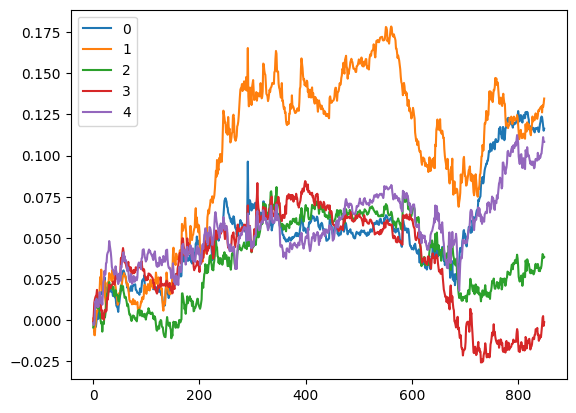

In [42]:
for i, ret in enumerate(test_returns):
  ret.cumsum().plot(label=i)
plt.legend()
plt.show()

<Axes: >

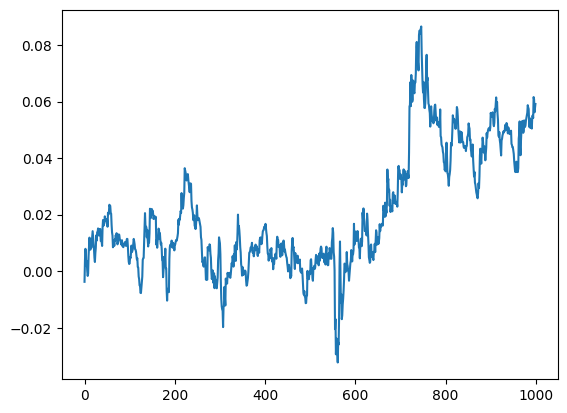

In [61]:
comb = pd.DataFrame(val_alphas[0] / 2 + val_alphas[4])
comb = comb.div(comb.abs().sum(axis=1), axis=0)
(comb.values * pd.DataFrame(y_val.detach().numpy(), columns=close.columns)).sum(axis=1).cumsum().plot()

In [21]:
val_sharpes = val_sharpes - val_sharpes.mean()
val_sharpes_coef = val_sharpes / np.abs(val_sharpes).sum()
val_sharpes_coef

array([ 0.19077496, -0.04692252, -0.36313742,  0.30922502, -0.08994003],
      dtype=float32)

In [22]:
import seaborn as sns

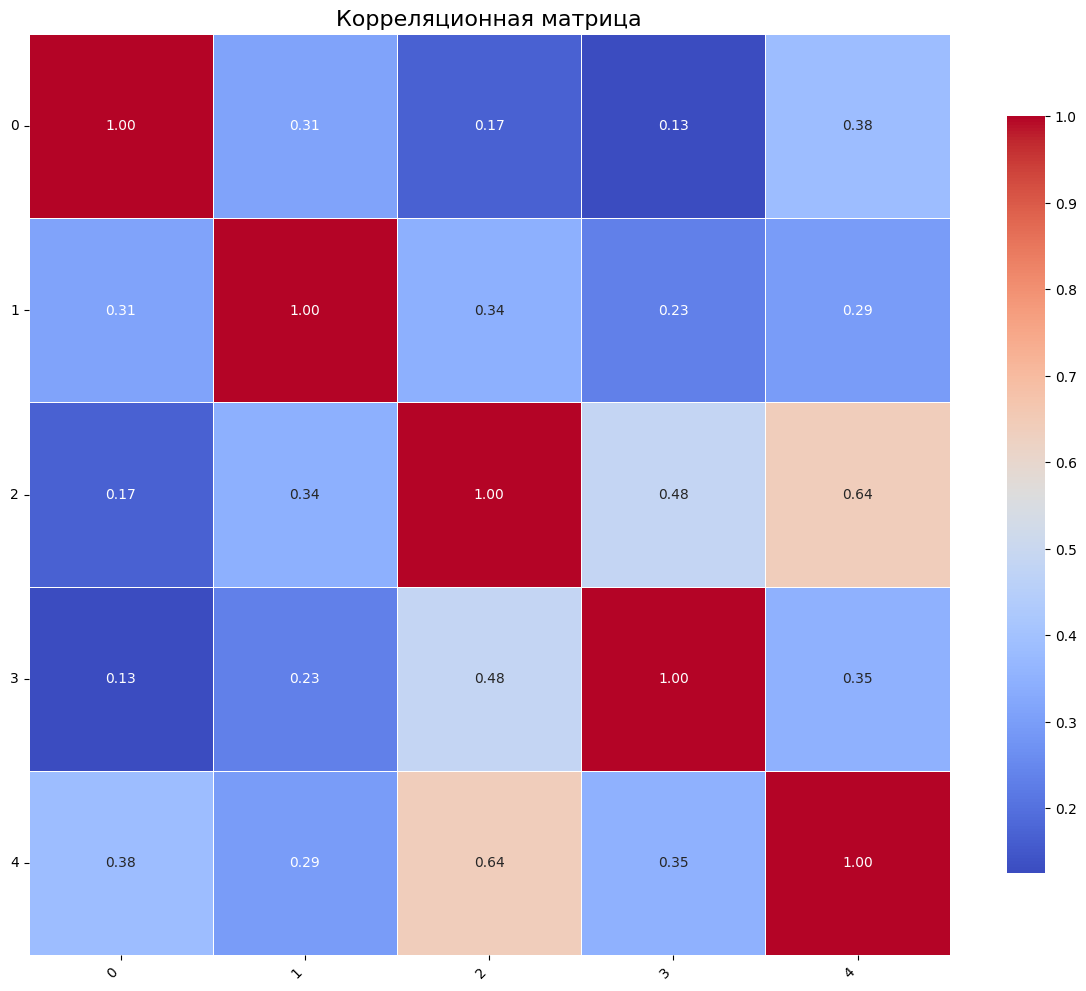

In [23]:
corr_matrix = pd.DataFrame(val_returns).T.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,  # Добавляет значения корреляции на карту
    fmt=".2f",   # Форматирование значений
    cmap='coolwarm',  # Цветовая палитра
    linewidths=.5,  # Ширина линий между ячейками
    cbar_kws={"shrink": .8},  # Уменьшение размера цветовой шкалы
    square=True,  # Сохраняет квадратную форму ячеек
)

plt.title('Корреляционная матрица', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [24]:
val_alphas = np.array(val_alphas)
test_alphas = np.array(test_alphas)

<Axes: >

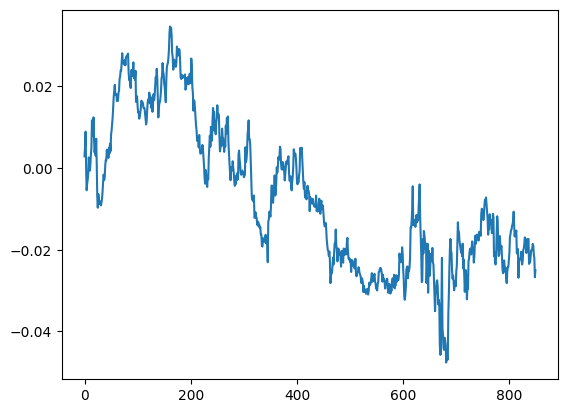

In [43]:
# Коэффициенты для линейной комбинации (должны быть 5 коэффициентов)
coefficients = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # Пример коэффициентов

# Проверяем, что количество коэффициентов соответствует количеству матриц
assert coefficients.shape[0] == val_alphas.shape[0], "Количество коэффициентов должно соответствовать количеству матриц."

# Создание линейной комбинации
val_linear_combination = np.tensordot(val_sharpes_coef, val_alphas, axes=(0, 0))
val_linear_combination = pd.DataFrame(val_linear_combination)
val_linear_combination = val_linear_combination.div(val_linear_combination.abs().sum(axis=1), axis=0)

# (val_linear_combination.values * pd.DataFrame(y_val.detach().numpy(), columns=close.columns)).sum(axis=1).cumsum().plot()

# Создание линейной комбинации
test_linear_combination = np.tensordot(val_sharpes_coef, test_alphas, axes=(0, 0))
test_linear_combination = pd.DataFrame(test_linear_combination)
test_linear_combination = test_linear_combination.div(test_linear_combination.abs().sum(axis=1), axis=0)

(test_linear_combination.values * pd.DataFrame(y_test.detach().numpy(), columns=close.columns)).sum(axis=1).cumsum().plot()

<Axes: >

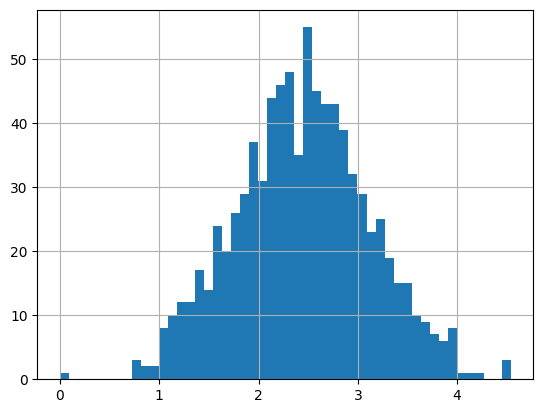

In [44]:
(test_linear_combination.diff().abs().sum(axis=1) * 4).hist(bins=50)

<Axes: >

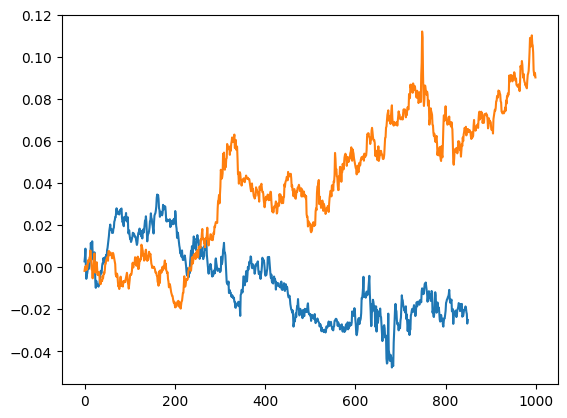

In [63]:
(
  test_linear_combination.values * \
  pd.DataFrame(y_test.detach().numpy(), columns=close.columns)
).sum(axis=1).cumsum().plot()

(
  val_linear_combination.ewm(com=10).mean().values * \
  pd.DataFrame(y_val.detach().numpy(), columns=close.columns)
).sum(axis=1).cumsum().plot()